In [1]:
# -*- coding: utf-8 -*-

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

-----

# 1. K-means Clustering

In [2]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print (x_train.shape)
print (x_test.shape)

Using TensorFlow backend.


(60000, 784)
(10000, 784)


In [121]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

model = KMeans(init="k-means++", n_clusters=10, random_state=0)
model.fit(x_train)
y_pred = model.labels_

In [118]:
def viz_img(y_pred):
    n = 10
    fig = plt.figure(1)
    box_index = 1
    for cluster in range(10):
        result = np.where(y_pred == cluster)
        for i in np.random.choice(result[0].tolist(), n, replace=False):
            ax = fig.add_subplot(n, n, box_index)
            plt.imshow(x_train[i].reshape(28, 28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            box_index += 1
    plt.show()

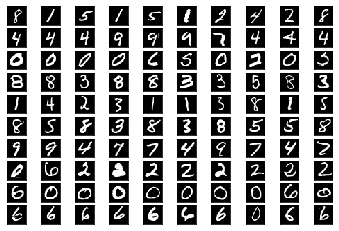

In [120]:
viz_img(y_pred)

-----

# 2. Spherical Clustering

In [46]:
!pip install spherecluster

In [122]:
from spherecluster import SphericalKMeans

skm = SphericalKMeans(n_clusters=10)
skm.fit(x_train)

SphericalKMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=10,
        n_init=10, n_jobs=1, normalize=True, random_state=None, tol=0.0001,
        verbose=0)

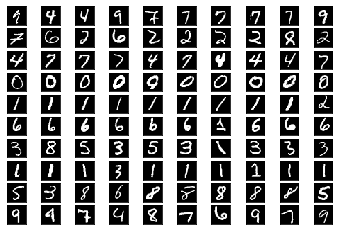

In [123]:
viz_img(skm.labels_)

------

# 3. PCA + K-means Clustering

In [130]:
from sklearn import decomposition

pca = decomposition.PCA(n_components=30).fit(x_train)
reduced_X = pca.transform(x_train)

In [131]:
sum(pca.explained_variance_ratio_)

0.7305345633067191

In [132]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

model = KMeans(init="k-means++", n_clusters=10, random_state=0)
model.fit(reduced_X)
y_pred = model.labels_

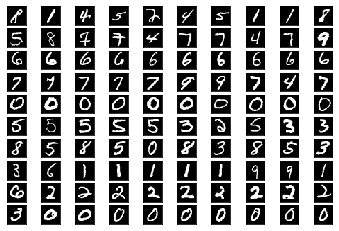

In [133]:
viz_img(y_pred)

-----

# 4. tSNE + DBSCAN Clustering

In [136]:
from sklearn.manifold import TSNE

model = TSNE(learning_rate=300)
transformed = model.fit_transform(x_train)

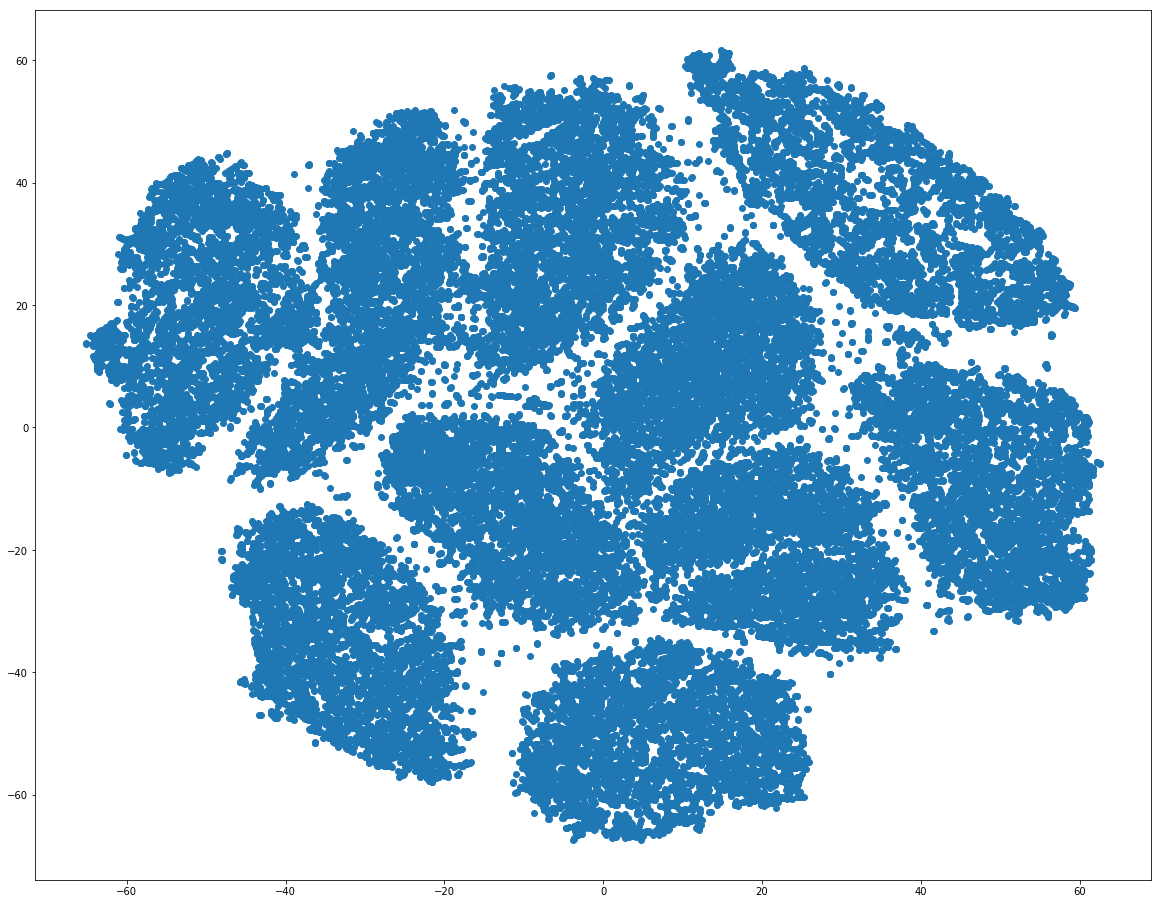

In [137]:
plt.rcParams['figure.figsize'] = [20, 16]
xs = transformed[:,0]
ys = transformed[:,1]
plt.scatter(xs,ys)
plt.show()

In [152]:
from sklearn.cluster import DBSCAN
model = DBSCAN(eps=2.4, min_samples=100)
predict = model.fit(transformed)
pd.Series(predict.labels_).value_counts()

 3    6578
 6    6152
 1    5948
 4    5891
 5    5841
 9    5839
 7    5609
 2    5570
 0    5395
 8    5333
-1    1844
dtype: int64

In [157]:
y_pred = predict.labels_

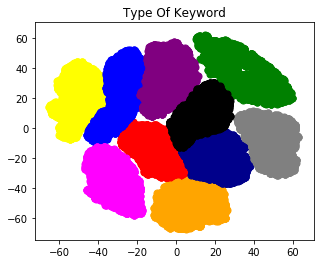

In [154]:
# Assign result to df
dataset = pd.DataFrame({'Column1':transformed[:,0],'Column2':transformed[:,1]})
dataset['cluster_num'] = pd.Series(predict.labels_)

# Cluster Viz 1
plt.rcParams['figure.figsize'] = [5, 4]
plt.scatter(dataset[dataset['cluster_num'] == 0]['Column1'], 
            dataset[dataset['cluster_num'] == 0]['Column2'], 
            s = 50, c = 'red', label = 'Customer Group 1')
plt.scatter(dataset[dataset['cluster_num'] == 1]['Column1'], 
            dataset[dataset['cluster_num'] == 1]['Column2'], 
            s = 50, c = 'orange', label = 'Customer Group 2')
plt.scatter(dataset[dataset['cluster_num'] == 2]['Column1'], 
            dataset[dataset['cluster_num'] == 2]['Column2'], 
            s = 50, c = 'yellow', label = 'Customer Group 3')
plt.scatter(dataset[dataset['cluster_num'] == 3]['Column1'], 
            dataset[dataset['cluster_num'] == 3]['Column2'], 
            s = 50, c = 'green', label = 'Customer Group 4')
plt.scatter(dataset[dataset['cluster_num'] == 4]['Column1'], 
            dataset[dataset['cluster_num'] == 4]['Column2'], 
            s = 50, c = 'blue', label = 'Customer Group 5')
plt.scatter(dataset[dataset['cluster_num'] == 5]['Column1'], 
            dataset[dataset['cluster_num'] == 5]['Column2'], 
            s = 50, c = 'darkblue', label = 'Customer Group 6')
plt.scatter(dataset[dataset['cluster_num'] == 6]['Column1'], 
            dataset[dataset['cluster_num'] == 6]['Column2'], 
            s = 50, c = 'purple', label = 'Customer Group 7')
plt.scatter(dataset[dataset['cluster_num'] == 7]['Column1'], 
            dataset[dataset['cluster_num'] == 7]['Column2'], 
            s = 50, c = 'gray', label = 'Customer Group 8')
plt.scatter(dataset[dataset['cluster_num'] == 8]['Column1'], 
            dataset[dataset['cluster_num'] == 8]['Column2'], 
            s = 50, c = 'black', label = 'Customer Group 9')
plt.scatter(dataset[dataset['cluster_num'] == 9]['Column1'], 
            dataset[dataset['cluster_num'] == 9]['Column2'], 
            s = 50, c = 'magenta', label = 'Customer Group 10')
plt.title('Type Of Keyword')
plt.show()

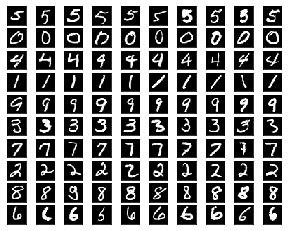

In [158]:
viz_img(y_pred)

-----

# 5. Autoencoder + Spherical Clustering

In [175]:
from keras.layers import Input, Dense
from keras.models import Model
from keras import backend as K

# configure
encoding_dim = 200
input_img = Input(shape=(784,))


# layers
encoded = Dense(encoding_dim, activation='relu')(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)


# Models
autoencoder = Model(input_img, decoded) # autoencoder

encoder = Model(input_img, encoded) # encoder

encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input)) # decoder

In [176]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

def recall(y_true, y_pred):
    y_true_yn = K.round(K.clip(y_true, 0, 1))
    y_pred_yn = K.round(K.clip(y_pred, 0, 1))

    count_true_positive = K.sum(y_true_yn * y_pred_yn)
    count_true_positive_false_negative = K.sum(y_true_yn)
    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())
    return recall


# train autoencoder
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=[rmse, recall])
autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=512,
                shuffle=True,
                validation_data=(x_test, x_test))


# encoding result
encoded_imgs = encoder.predict(x_train)
decoded_imgs = decoder.predict(encoded_imgs)

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 3s 43us/step - loss: 0.3887 - rmse: 0.3167 - recall: 0.2615 - val_loss: 0.2735 - val_rmse: 0.2589 - val_recall: 0.2201
Epoch 2/100
60000/60000 [==============================] - 2s 36us/step - loss: 0.2655 - rmse: 0.2539 - recall: 0.2573 - val_loss: 0.2557 - val_rmse: 0.2481 - val_recall: 0.3156
Epoch 3/100
60000/60000 [==============================] - 2s 36us/step - loss: 0.2484 - rmse: 0.2418 - recall: 0.3497 - val_loss: 0.2384 - val_rmse: 0.2346 - val_recall: 0.3921
Epoch 4/100
60000/60000 [==============================] - 2s 36us/step - loss: 0.2318 - rmse: 0.2287 - recall: 0.4520 - val_loss: 0.2225 - val_rmse: 0.2218 - val_recall: 0.4950
Epoch 5/100
60000/60000 [==============================] - 2s 36us/step - loss: 0.2174 - rmse: 0.2172 - recall: 0.5315 - val_loss: 0.2094 - val_rmse: 0.2113 - val_recall: 0.5634
Epoch 6/100
60000/60000 [==============================] - 2

60000/60000 [==============================] - 2s 36us/step - loss: 0.1043 - rmse: 0.1074 - recall: 0.8697 - val_loss: 0.1026 - val_rmse: 0.1057 - val_recall: 0.8669
Epoch 47/100
60000/60000 [==============================] - 2s 37us/step - loss: 0.1035 - rmse: 0.1064 - recall: 0.8710 - val_loss: 0.1017 - val_rmse: 0.1045 - val_recall: 0.8701
Epoch 48/100
60000/60000 [==============================] - 2s 37us/step - loss: 0.1027 - rmse: 0.1053 - recall: 0.8724 - val_loss: 0.1009 - val_rmse: 0.1034 - val_recall: 0.8725
Epoch 49/100
60000/60000 [==============================] - 2s 36us/step - loss: 0.1019 - rmse: 0.1043 - recall: 0.8738 - val_loss: 0.1002 - val_rmse: 0.1024 - val_recall: 0.8759
Epoch 50/100
60000/60000 [==============================] - 2s 37us/step - loss: 0.1012 - rmse: 0.1033 - recall: 0.8751 - val_loss: 0.0994 - val_rmse: 0.1014 - val_recall: 0.8772
Epoch 51/100
60000/60000 [==============================] - 2s 36us/step - loss: 0.1005 - rmse: 0.1024 - recall: 0.876

Epoch 92/100
60000/60000 [==============================] - 2s 36us/step - loss: 0.0851 - rmse: 0.0800 - recall: 0.9048 - val_loss: 0.0838 - val_rmse: 0.0785 - val_recall: 0.9056
Epoch 93/100
60000/60000 [==============================] - 2s 34us/step - loss: 0.0849 - rmse: 0.0796 - recall: 0.9052 - val_loss: 0.0837 - val_rmse: 0.0781 - val_recall: 0.9086
Epoch 94/100
60000/60000 [==============================] - 2s 36us/step - loss: 0.0847 - rmse: 0.0793 - recall: 0.9057 - val_loss: 0.0835 - val_rmse: 0.0778 - val_recall: 0.9078
Epoch 95/100
60000/60000 [==============================] - 2s 36us/step - loss: 0.0845 - rmse: 0.0790 - recall: 0.9061 - val_loss: 0.0833 - val_rmse: 0.0774 - val_recall: 0.9100
Epoch 96/100
60000/60000 [==============================] - 2s 36us/step - loss: 0.0843 - rmse: 0.0787 - recall: 0.9065 - val_loss: 0.0831 - val_rmse: 0.0772 - val_recall: 0.9102
Epoch 97/100
60000/60000 [==============================] - 2s 36us/step - loss: 0.0841 - rmse: 0.0784 - 

In [177]:
encoded_imgs.shape

(60000, 200)

In [180]:
from spherecluster import SphericalKMeans

skm = SphericalKMeans(n_clusters=10)
skm.fit(x_train)

SphericalKMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=10,
        n_init=10, n_jobs=1, normalize=True, random_state=None, tol=0.0001,
        verbose=0)

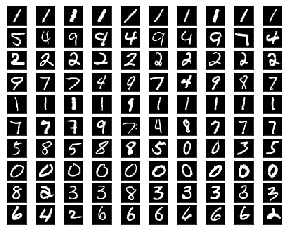

In [181]:
viz_img(skm.labels_)